In [1]:
%load_ext autoreload
%autoreload 2 

# Deep learning tips and tricks: Data augmentation and Transfer learning

**What you will learn today**: You will learn how to improve the performance of a deep neural network by increasing the effective data available for training using data augmentation. You will also learn how to leverage large pretrained models to boost the performance of a downstream task using transfer learning.

## On the previous episode...

On the previous lab we explored different techniques to train neural networks and implemented them using `PyTorch`. Our experiments showed that choosing the right learning rate and architecture are fundamental to generalize on a complex dataset such as CIFAR10. We learned how modern optimizers work, and explored new architectural concepts such as batch normalization and skip connections.

In this lab, we will continue this journey and investigate other techniques to improve performance of a neural network. In particular, we will see how one can exploit the flexibility of stochastic gradient descent to increase our effective data available, and how we can leverage large pretrained models to initialize our networks in a smart way.

Specifically, we will talk about:
* Data augmentation
* Transfer learning

So... let's get started!


For convenience, we copy-paste the necessary code from the previous lab. 

For every model we want to create, we will create a new class that inherits `BasicModel` and implemements the `__init__` and `forward` functions. 

# Data augmentation
Data augmentation is a training technique which consists in transforming every batch of data shown to the model using some random operation which generates a new ''view'' of each sample that retains its semantic information. For example, in the context of image classification, the label of most objects remains the same if you mirror them horizontally. Therefore, a cheap way to increase your training data, is to ''augment'' each sample by introducing its mirrored counterpart.

Let's do it!

In [2]:
# first we load all the necessary libraries
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

from training_utils import fit, predict, plot_loss, visualize_images

In `PyTorch`, the data augmentation operations are included in the transformation pipeline of a dataset. You can find more details on the [official documentation](https://pytorch.org/vision/stable/transforms.html).

In [3]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip() # We want to randomly apply a random flip to every sample
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(), 
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In `PyTorch`, any `nn.Module` can be included in a transform pipeline. Every time you ask for a sample `x`, `PyTorch` calls `transform.forward(x)` before feeding it to the model. This means we can easily visualize the effect of data augmentation.

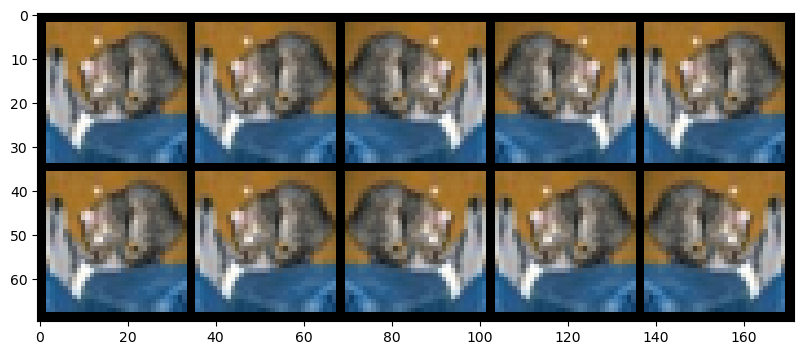

In [4]:
im, _ = test_dataset[0]
im = im[None, ...] # We need a leading batch dimension to feed to the model

images_rot = torch.cat([T.RandomHorizontalFlip()(im) for _ in range(10)])

grid = torchvision.utils.make_grid(images_rot, nrow=5, padding=2)
# Just normalization for test data
plt.figure(figsize=(20,4))
plt.imshow(grid.permute([1,2,0]))

Horizontal flips are a bit obvious. We can get more creative with data augmentation. However, bare in mind that some transformations might destroy important information of your data, so be careful when applying it.

CIFAR10 is relatively easy, so the following transformations are enough to achieve good performance.

In [5]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=[32,32], padding=4)
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(), 
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=test_transform)

# we make the Batch_sizes smaller for computational reasons
# we will later use larger models and memory might become an issue
BATCH_SIZE = 256

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Let's train a **ResNet**! Since it is a standard model, it is already implemented in the `torchvision` library and we can use it directly.

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [7]:
print(f"Using device: {DEVICE}")

Using device: mps


Epoch 0: Loss=2.010443091392517
Epoch 1: Loss=1.5686627492612721
Epoch 2: Loss=1.3302452740620594
Epoch 3: Loss=1.147473165575339
Epoch 4: Loss=1.0220719648867238
Epoch 5: Loss=0.9389940010649818
Epoch 6: Loss=0.8613818117550441
Epoch 7: Loss=0.807638593474213
Epoch 8: Loss=0.7594813731860142
Epoch 9: Loss=0.7232102183054905
Epoch 10: Loss=0.6856290314878736
Epoch 11: Loss=0.6583194224810114
Epoch 12: Loss=0.6370730503481261
Epoch 13: Loss=0.608617750965819
Epoch 14: Loss=0.5925715875868894
Epoch 15: Loss=0.5730045527523878
Epoch 16: Loss=0.5513367719796239
Epoch 17: Loss=0.534045332396517
Epoch 18: Loss=0.5169732664920845
Epoch 19: Loss=0.507690295729102
Epoch 20: Loss=0.4991815157082616
Epoch 21: Loss=0.4792474900581399
Epoch 22: Loss=0.46207287284184473
Epoch 23: Loss=0.4528353161045483
Epoch 24: Loss=0.44855905582710187
Epoch 25: Loss=0.4326334043729062
Epoch 26: Loss=0.4287459769723367
Epoch 27: Loss=0.413169262512606
Epoch 28: Loss=0.40312632675073584
Epoch 29: Loss=0.40932014767

(0.6310913376808166, tensor(80.4200, device='mps:0'))

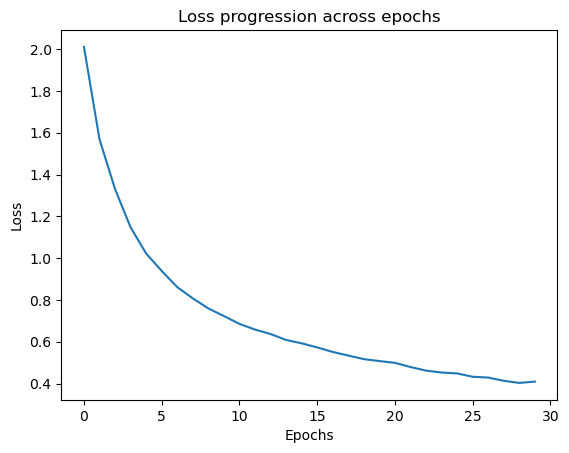

In [8]:

from torchvision.models.resnet import resnet18

model = resnet18(num_classes=10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
    )
)

# predict with the trained model
predict(
        model,
        test_dataloader = test_dataloader,
        device = DEVICE,
    )

# Transfer learning

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Transfer learning refers to the concept of initializing a neural network using the weights learned on a different task before training. Surprisingly, if the pretraining dataset is large enough, but also semantically ''close'' to the downstream task, using transfer learning, instead of regular training from random weights can significantly boost performance. Intuitively, transfer learning allows to recycle the features learned with a lot of data on the pretraining task, and leverage them to classify a new dataset.

Let's see this in practice. To that end, we will follow the [PyTorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which is an excellent resource to learn how to implement advanced techniques in deep learning. We will minimally adapt the code to fit our streamlined API from the previous labs.

Let's download our data...

In [10]:
import requests
import os

remote_url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'

local_file = './data/hymenoptera_data.zip'
os.makedirs('./data', exist_ok=True)

data = requests.get(remote_url)

# Save file data to local copy
with open(local_file, 'wb')as file:
    file.write(data.content)

and extract it...

In [11]:
from zipfile import ZipFile
  
# opening the zip file in READ mode
with ZipFile(local_file, 'r') as zip:
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall('./data')
    print('Done!')

Extracting all the files now...
Done!


We can work with this data directly using `torchvision`

In [12]:
# Data augmentation and normalization for training
# The normalization values are the average and std of each channel, precomputed
# on the training images
train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for test data
test_transform =  T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    # Should we add the same normalization for test as we did for train? Explain.
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])


data_dir = 'data/hymenoptera_data'
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), test_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

train_size = len(train_dataset)
test_size = len(test_dataset)
class_names = train_dataset.classes

Yes, the same normalization must be applied to both training and test data. Normalization aligns the input distribution with the one seen during training, while data augmentation is used only for training. Omitting normalization at test time would introduce a distribution shift and degrade performance.

Let's visualize a few images

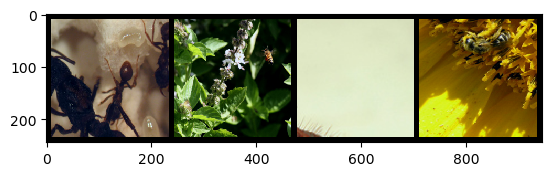

In [13]:
visualize_images(
    train_dataloader,
    mean=torch.tensor([0.485, 0.456, 0.406]),
    std=torch.tensor([0.229, 0.224, 0.225]),
)

There are two major transfer learning techniques depending on which parts of the network are updated using the new data:
1. Finetuning the full network
2. Finetuning only the last layer

First let's see how a randomly initialized model performs!

Epoch 0: Loss=0.8876780882844182
Epoch 1: Loss=0.8969738761909672
Epoch 2: Loss=0.7449294211434536
Epoch 3: Loss=0.7519397237261788
Epoch 4: Loss=0.764987869829428
Epoch 5: Loss=0.8002441574315555
Epoch 6: Loss=0.7025884985923767
Epoch 7: Loss=0.6181319622231312
Epoch 8: Loss=0.7923268998255495
Epoch 9: Loss=1.042800075695163
Epoch 10: Loss=0.7454152573816112
Epoch 11: Loss=0.7264254303252111
Epoch 12: Loss=0.6702713869878503
Epoch 13: Loss=0.5717366108151732
Epoch 14: Loss=0.6167045668011806
Epoch 15: Loss=0.6677786629708087
Epoch 16: Loss=0.6375943004596428
Epoch 17: Loss=0.6844216677986208
Epoch 18: Loss=0.7262026017806569
Epoch 19: Loss=0.7082019470265655
Epoch 20: Loss=0.6352792829275131
Epoch 21: Loss=0.7602069573324235
Epoch 22: Loss=0.6555029567880709
Epoch 23: Loss=0.6216603876625906
Epoch 24: Loss=0.5922202353106171
Test set: Avg. loss: 1.9528, Accuracy: 73/153 (48%)


(1.9527725519892436, tensor(47.7124, device='mps:0'))

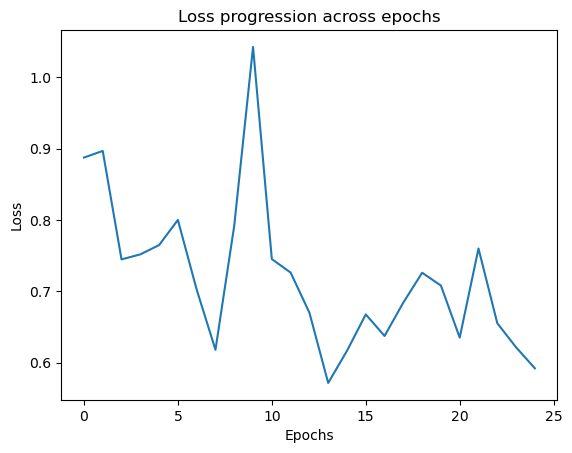

In [14]:
# the model is a resnet18. How many outputs should it have?
model = resnet18(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the full network
Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. The rest of the training looks as usual, albeit normally using a significantly smaller learning rate.


In [15]:
import torch.nn as nn

class FinetuningFullModel(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # load pretrained resnet18
        self.network = resnet18(pretrained=True)
        # change the last layer with a randonly initializied one and with `num_classes` number of output neurons.
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, x):
        return self.network(x)

Let's train it...

/opt/anaconda3/envs/env310torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/env310torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/xieqilin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Epoch 0: Loss=0.7034356434081421
Epoch 1: Loss=0.6319241604279177
Epoch 2: Loss=0.44776807125413515
Epoch 3: Loss=0.3806284608349937
Epoch 4: Loss=0.44714873933737154
Epoch 5: Loss=0.733843986654929
Epoch 6: Loss=0.41785559152848406
Epoch 7: Loss=0.5166374706647924
Epoch 8: Loss=0.4897825604869572
Epoch 9: Loss=0.37120209715222235
Epoch 10: Loss=0.3635667365227566
Epoch 11: Loss=0.4694272095917678
Epoch 12: Loss=0.33493910279682243
Epoch 13: Loss=0.425212729554318
Epoch 14: Loss=0.5972388915366448
Epoch 15: Loss=0.5867007755766027
Epoch 16: Loss=0.6512972379072768
Epoch 17: Loss=0.43805969040459175
Epoch 18: Loss=0.44178729344800605
Epoch 19: Loss=0.5311057651568143
Epoch 20: Loss=0.6693524189110174
Epoch 21: Loss=0.4615823883738857
Epoch 22: Loss=0.3160328913907536
Epoch 23: Loss=0.3589250067340546
Epoch 24: Loss=0.4396248737614426
Test set: Avg. loss: 0.2527, Accuracy: 141/153 (92%)


(0.25273150978380704, tensor(92.1569, device='mps:0'))

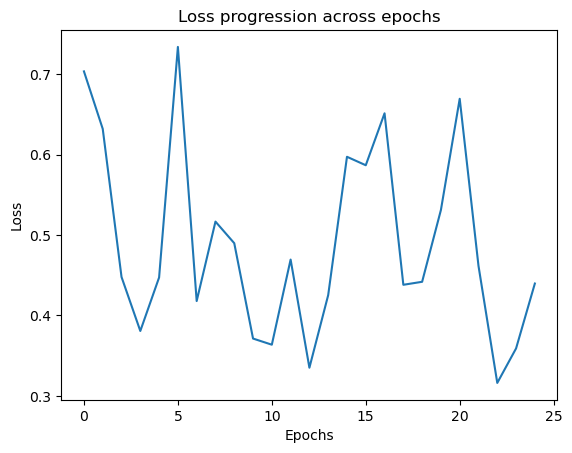

In [ ]:
model = FinetuningFullModel(num_classes=len(class_names)).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the last layer

Sometimes finetuning all the parameters of a large model is too expensive, or unstable. In those cases, one can alternatively 'freeze' some parts of the network, and train only the latter parts. Most often, just tuning the last layer is enough to get good enough results, with the optimal performance normally achieved by finetuning a few of the last layers.

In [17]:
class FinetuningLastLayer(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # load pretrained resnet18
        self.network = resnet18(pretrained=True)

        # freeze the parameters of the network.
        for param in self.network.parameters():
            param.requires_grad = False

        # replace the last layer with a randonly initializied one and with `num_classes` number of output neurons.
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, x):
        return self.network(x)

Epoch 0: Loss=0.6418588267730885
Epoch 1: Loss=0.6432239256921362
Epoch 2: Loss=0.6058935110503044
Epoch 3: Loss=0.3285982681774214
Epoch 4: Loss=0.6984540503014063
Epoch 5: Loss=0.44162463115864115
Epoch 6: Loss=0.40065662910948036
Epoch 7: Loss=0.7107699270833467
Epoch 8: Loss=0.44719720769246096
Epoch 9: Loss=0.5020412107410489
Epoch 10: Loss=0.30439325254105154
Epoch 11: Loss=0.47616489182730193
Epoch 12: Loss=0.41086803901879515
Epoch 13: Loss=0.45682901366934425
Epoch 14: Loss=0.44536710974042776
Epoch 15: Loss=0.5851975617105843
Epoch 16: Loss=0.27150980781641654
Epoch 17: Loss=0.5348375526974436
Epoch 18: Loss=0.3760964106463018
Epoch 19: Loss=0.33807269872746387
Epoch 20: Loss=0.46053944331151053
Epoch 21: Loss=0.4491447176265179
Epoch 22: Loss=0.3950947125243848
Epoch 23: Loss=0.45396755622760926
Epoch 24: Loss=0.7088644624989267
Test set: Avg. loss: 0.2130, Accuracy: 143/153 (93%)


(0.2129667113293157, tensor(93.4641, device='mps:0'))

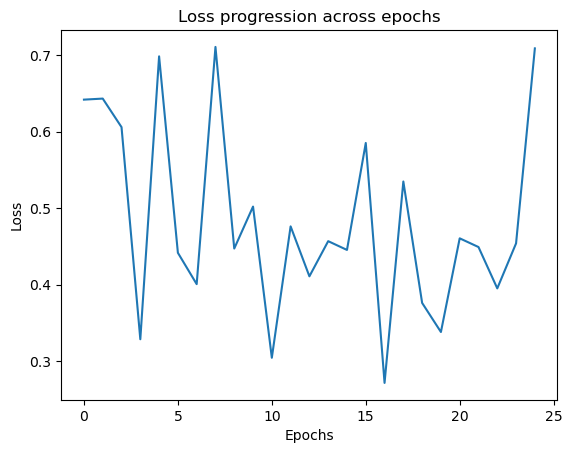

In [20]:
model = FinetuningLastLayer(num_classes=len(class_names)).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)